# Importing GDS files

<img src="img/splitter.png" alt="Schematic of the directional coupler" width="400"/>

In `Tidy3D`, complex structures can be defined or imported from GDSII files via the third-party [gdstk](https://heitzmann.github.io/gdstk/) package. In this tutorial, we will first illustrate how to use the package to define a structure, then we will save this to file, and then we will read that file and import the structures in a simulation.

Note that this tutorial requires gdstk, so grab it with `pip install gdstk` before running the tutorial or uncomment the cell line below.

We also provide a conprehensive list of other tutorials such as [how to define boundary conditions](https://www.flexcompute.com/tidy3d/examples/notebooks/BoundaryConditions/), [how to compute the S-matrix of a device](https://www.flexcompute.com/tidy3d/examples/notebooks/SMatrix/), [how to interact with tidy3d's web API](https://www.flexcompute.com/tidy3d/examples/notebooks/WebAPI/), and [how to define self-intersecting polygons](https://www.flexcompute.com/tidy3d/examples/notebooks/SelfIntersectingPolyslab/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import gdstk
import os

# tidy3d import
import tidy3d as td
from tidy3d import web


## Creating a beam splitter with gdstk

First, we will construct an integrated beam splitter as in the title image in this notebook using `gdstk`. If you are only interested in importing an already existing GDSII file, just jump ahead to the next section.

We first define some structural parameters. We consider the sidewall of the device to be slanted, deviating from the vertical sidewall by `sidewall_angle`. `sidewall_angle > 0` corresponds to a typical fabrication scenario where the base of the device is larger than the top.

We define the device by constructing the cross section of the device. The cross section can be supplied at the `top`, `bottom`, or the `middle` of the device, specified by the parameter `reference_plane`. Here we choose to define the cross section on the base. On the base, the two arms of the device start at a distance `wg_spacing_in` apart, then come together at a coupling distance `wg_spacing_coup` for a certain length `coup_length`, and then split again into separate ports. In the coupling region, the field overlap results in energy exchange between the two waveguides. Here, we will only see how to define, export, and import such a device using `gdstk`. When importing the device, we can optionally dilate or erode its cross section via `dilation`. In a later example we will simulate the device and study the frequency dependence of the transmission into each of the ports.

In [2]:
### Lengths in micrometers

# Waveguide width
wg_width = 0.45

# Waveguide separation in the beginning/end
wg_spacing_in = 8

# Length of the coupling region
coup_length = 10

# Angle of the sidewall deviating from the vertical ones, positive values for the base larger than the top
sidewall_angle = np.pi / 6

# Reference plane where the cross section of the device is defined
reference_plane = "bottom"

# Length of the bend region
bend_length = 16

# Waveguide separation in the coupling region
wg_spacing_coup = 0.10

# Total device length along propagation direction
device_length = 100


### Generating Geometry
To create the device, we will use the `RobustPath` class to define two parallel waveguide with a variable distance between them.  First, we define a helper fuction that will give the shape of the waveguides in the S-bends that bring them together and then apart.  The distance between them (described by the `offset` parameter in `RobustPath`) will follow a hyperbolic tangent function, so we create a helper function that simple produces a normalized version of _tanh_ in the unit interval.

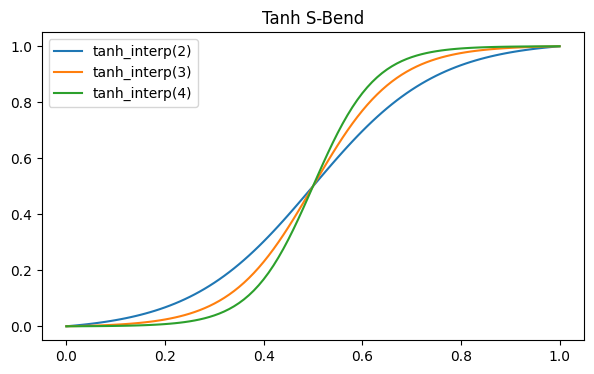

In [3]:
def tanh_interp(max_arg):
    """Interpolator for tanh with adjustable extension"""
    scale = 1 / np.tanh(max_arg)
    return lambda u: 0.5 * (1 + scale * np.tanh(max_arg * (u * 2 - 1)))


fig, ax = plt.subplots(1, figsize=(7, 4))
x = np.linspace(0, 1, 101)
for max_arg in [2, 3, 4]:
    s_bend = tanh_interp(max_arg)
    ax.plot(x, s_bend(x), label=f"tanh_interp({max_arg})")
ax.set_title("Tanh S-Bend")
_ = ax.legend()


We use `tanh_interp(3)` for our waveguides and put the whole geometry creation steps in convenience function. The [documentation for RobustPath](https://heitzmann.github.io/gdstk/geometry/gdstk.RobustPath.html) has more details on the use of that class.

In [4]:
def make_coupler(
    length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
):
    """Make an integrated coupler using the gdstk RobustPath object."""
    # bend interpolator
    interp = tanh_interp(3)
    delta = wg_width + wg_spacing_coup - wg_spacing_in
    offset = lambda u: wg_spacing_in + interp(u) * delta

    coup = gdstk.RobustPath(
        (-0.5 * length, 0),
        (wg_width, wg_width),
        wg_spacing_in,
        simple_path=True,
        layer=1,
        datatype=[0, 1],
    )
    coup.segment((-0.5 * coup_length - bend_length, 0))
    coup.segment(
        (-0.5 * coup_length, 0),
        offset=[lambda u: -0.5 * offset(u), lambda u: 0.5 * offset(u)],
    )
    coup.segment((0.5 * coup_length, 0))
    coup.segment(
        (0.5 * coup_length + bend_length, 0),
        offset=[lambda u: -0.5 * offset(1 - u), lambda u: 0.5 * offset(1 - u)],
    )
    coup.segment((0.5 * length, 0))
    return coup


### Writing to GDS cells

Next, we construct the splitter and write it to a GDS cell. We add a rectangle for the substrate to layer 0, and in layer 1 we add two paths, one for the upper and one for the lower splitter arms, and set the path width to be the waveguide width defined above.

We also store the cell in a library that is saved to a file, so that we can demosntrate how to load the geometry straight from a gds file. Alternatively, we could use the created cell directly.

In [5]:
# Create a gds cell to add our structures to
coup_cell = gdstk.Cell("COUPLER")

# make substrate and add to cell
substrate = gdstk.rectangle(
    (-device_length / 2, -wg_spacing_in / 2 - 10),
    (device_length / 2, wg_spacing_in / 2 + 10),
    layer=0,
)

coup_cell.add(substrate)

# make coupler and add to the cell
coup = make_coupler(
    device_length, wg_spacing_in, wg_width, wg_spacing_coup, coup_length, bend_length
)

coup_cell.add(coup)

# Create a library for the cell and save it, just so that we can demosntrate loading
# geometry from a gds file
gds_path = "misc/coupler.gds"

if os.path.exists(gds_path):
    os.remove(gds_path)

lib = gdstk.Library()
lib.add(coup_cell)
lib.write_gds(gds_path)


## Loading a GDS file into Tidy3D

To load the geometry from a GDSII file, we use gdstk to load the library and select the cell with the geometry we want.
It is usualy esier to create a dictionary of all the cells in the library to verify that we can find the correct one by name:

In [6]:
# Load a GDSII library from the file we just created
lib_loaded = gdstk.read_gds(gds_path)

# Create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}

print("Cell names: " + ", ".join(all_cells.keys()))


Cell names: COUPLER


In this case, we only have the single cell that we created previously, called “COUPLER”, but usually GDSII files hold tens to hundreds of cells, so it is important to find them by name. Getting to the cell we're interested in now is as simple as:

In [7]:
coup_cell_loaded = all_cells["COUPLER"]

print(coup_cell_loaded)


Cell 'COUPLER' with 1 polygons, 2 flexpaths, 0 robustpaths, 0 references, and 0 labels


### Set up Geometries

Then we can construct tidy3d geometries from the GDS cell we just loaded, along with other information such as the axis, sidewall angle, and bounds of the "slab". When loading GDS cell as the cross section of the device, we can tune ``reference_plane`` to set the cross section to lie at ``bottom``, ``middle``, or ``top`` of the generated [Polyslab](../_autosummary/tidy3d.PolySlab.html) with respect to the axis. E.g. if ``axis=1``, ``bottom`` refers to the negative side of the y-axis, and ``top`` refers to the positive side of the y-axis. Additionally, we can optionally dilate or erode the cross section by setting `dilation`. A negative `dilation` corresponds to erosion.

Note, we have to keep track of the `gds_layer` and `gds_dtype` used to defined the GDS cell earlier, so we can load the right components.

In [8]:
# Define waveguide height
wg_height = 0.22
dilation = 0.02

substrate_geo = td.Geometry.from_gds(
    coup_cell_loaded,
    gds_layer=0,
    gds_dtype=0,
    axis=2,
    slab_bounds=(-430, 0),
    reference_plane=reference_plane,
)

arms_geo = td.Geometry.from_gds(
    coup_cell_loaded,
    gds_layer=1,
    axis=2,
    slab_bounds=(0, wg_height),
    sidewall_angle=sidewall_angle,
    dilation=dilation,
    reference_plane=reference_plane,
)


Let's plot the base and the top of the coupler waveguide arms to make sure it looks ok. The base of the device should be larger than the top due to a positive `sidewall_angle`.

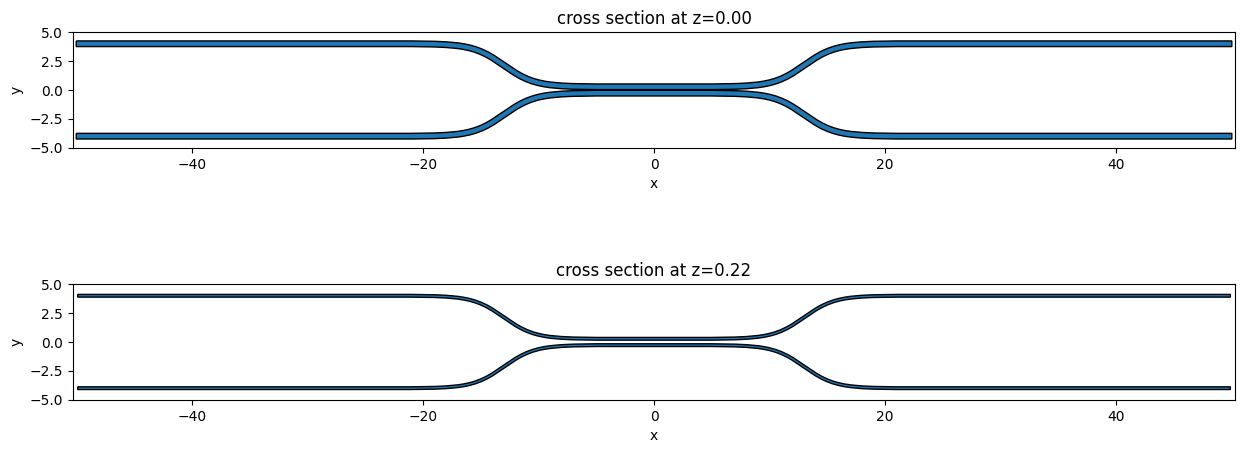

In [9]:
f, ax = plt.subplots(2, 1, figsize=(15, 6))
arms_geo.plot(z=0.0, ax=ax[0])
arms_geo.plot(z=wg_height, ax=ax[1])

ax[0].set_ylim(-5, 5)
_ = ax[1].set_ylim(-5, 5)

### Set up Structures

To make use of these new geometries, we need to load them into a tidy3d.Simulation as td.Structures with material properties.

We'll define the substrate and waveguide mediums and then link them up with the Polyslabs.

In [10]:
# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
medium_wg = td.Medium(permittivity=wg_n**2)
medium_sub = td.Medium(permittivity=sub_n**2)

# Substrate
substrate = td.Structure(
    geometry=substrate_geo,  # td.Box(center=(0, 0, -td.inf/2), size=(td.inf, td.inf, td.inf)),
    medium=medium_sub,
)

# Waveguides (import all datatypes if gds_dtype not specified)
arms = td.Structure(geometry=arms_geo, medium=medium_wg)

structures = [substrate, arms]


### Set up Simulation

Now let's set up the rest of the Simulation.

In [11]:
# Simulation size along propagation direction
sim_length = 2 + 2 * bend_length + coup_length

# Spacing between waveguides and PML
pml_spacing = 1
sim_size = (
    np.ceil(sim_length),
    np.ceil(wg_spacing_in + wg_width + 2 * pml_spacing),
    np.ceil(wg_height + 2 * pml_spacing),
)

# grid size in each direction
dl = 0.020

### Initialize and visualize simulation ###
sim = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec.uniform(dl=dl),
    structures=structures,
    run_time=2e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


Note: `Tidy3D` is warning us that our Simulation does not contain sources. In this case, since we are using the simulation as a demonstration and are not running any simulations, we may safely ignore this warning throughout this notebook.

### Plot Simulation Geometry

Let's take a look at the simulation all together with the PolySlabs added. Here the angle of the sidewall deviating from the vertical direction is 30 degree.

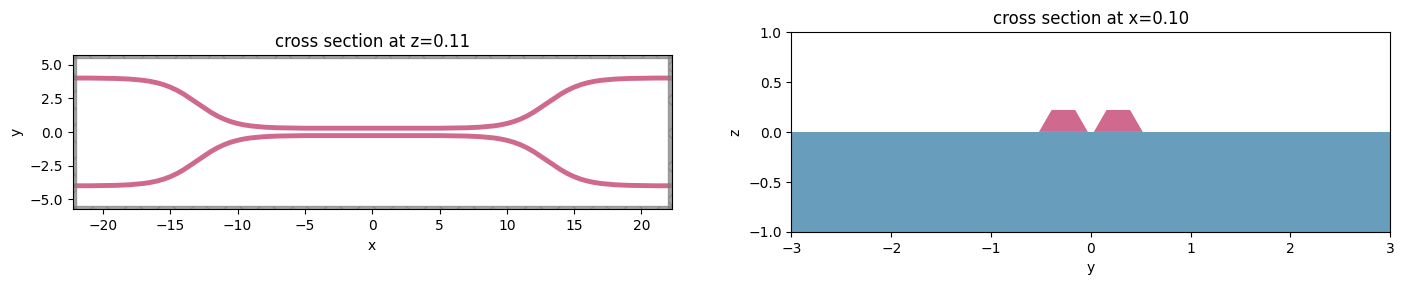

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))

sim.plot(z=wg_height / 2, lw=1, edgecolor="k", ax=ax1)
sim.plot(x=0.1, lw=1, edgecolor="k", ax=ax2)

ax2.set_xlim([-3, 3])
_ = ax2.set_ylim([-1, 1])
